# Cholera

In [1]:
import jax
import itertools
import numpy as onp
import jax.numpy as np
import ipywidgets as widgets
import pandas as pd

from jax.numpy.linalg import inv, pinv
from jax.scipy.optimize import minimize
from scipy.linalg import solve_discrete_are as dare
from jax import jit, grad
from IPython import display
from toolz.dicttoolz import valmap, itemmap
from itertools import chain
from functools import partial

from tqdm.notebook import tqdm
from tensorflow_probability.substrates import jax as tfp
tfd = tfp.distributions
tfb = tfp.bijectors
tfpk = tfp.math.psd_kernels

from pomps import *
from resampling import *
from filtering import *
from optim import *

import matplotlib.pyplot as plt
plt.style.use('matplotlibrc')
onp.set_printoptions(suppress=True)

2023-08-06 20:30:14.160127: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
dataset = pd.read_csv('data/dacca/dacca.csv', index_col=0).reset_index(drop=True)
ys = np.array(dataset['cholera.deaths'].values)
dataset = pd.read_csv('data/dacca/covars.csv', index_col=0).reset_index(drop=True)
dataset.index = pd.read_csv('data/dacca/covart.csv', index_col=0).reset_index(drop=True).squeeze()
dataset = dataset.reindex(onp.array([1891 + i*(1/240) for i in range(12037)])).interpolate()
covars = np.array(dataset.values)#[20:]
#gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, k, delta = 8.0, 9.238, 7.1, 0.7, onp.exp(-4.5), 0.0051, (-6.8*10**(-3)), 639.6, 0.23, np.array([6.5,11.4,2.1,9.0,8.6,9.5]), 3, 0.02
#gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, k, delta = 17.3, 0.057, 0, 9.8, onp.exp(-4.8), 0.999999, (-5.0*10**(-3)), 3.2, 0.25, np.array([1.2,6.2,-3.4,3.9,3.2,4.3]), 3, 0.02


gamma = 20.8
epsilon = 19.1
rho = 0
delta = 0.02
m = 0.06
c = np.array(1)
beta_trend = -0.00498
bs = np.array([0.747, 6.38, -3.44, 4.23, 3.33, 4.55])
sigma = 3.13 #3.13 # 0.77
tau = 0.23 
omega = onp.exp(-4.5)
omegas = np.log(np.array([0.184, 0.0786, 0.0584, 0.00917, 0.000208, 0.0124]))


theta = transform_thetas(gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas)

In [3]:
def pfilter_helper_debug(t, inputs):
    particlesF, theta, covars, loglik, norm_weights, counts, ys, thresh, key, pfs = inputs
    J = len(particlesF)
    
    key, *keys = jax.random.split(key, num=J+1)
    keys = np.array(keys)
        
    # Get prediction particles 
    if covars is not None:
        particlesP = rprocess(particlesF, theta, keys, covars)# if t>0 else particlesF
    else:
        particlesP = rprocess(particlesF, theta, keys, None)

    oddr = np.exp(np.max(norm_weights))/np.exp(np.min(norm_weights))
    # Systematic resampling
    counts, particlesF, weights = jax.lax.cond(oddr > thresh, 
                                               resampler, 
                                               no_resampler, 
                                               counts, particlesP, norm_weights)

    # Multiply weights by measurement model result
    weights += dmeasure(ys[t], particlesP, theta) #shape (Np,)

    # Obtain normalized weights
    norm_weights, loglik_t = normalize_weights(weights)

    # Sum up loglik
    loglik = loglik.at[t].set(loglik_t)
    #jax.debug.print(loglik, loglik_t)
    
    pfs = pfs.at[t].set(particlesF)
    
    return [particlesF, theta, covars, loglik, norm_weights, counts, ys, thresh, key, pfs]

@partial(jit, static_argnums=2)
def pfilter_debug(theta, ys, J, covars=None, thresh=100, key=None):
    if key is None:
        key = jax.random.PRNGKey(onp.random.choice(10000))
    
    particlesF = rinit(theta, J, covars=covars)
    weights = np.log(np.ones(J)/J)
    norm_weights = np.log(np.ones(J)/J)
    counts = np.ones(J).astype(int)
    loglik = np.zeros(len(ys))
    
    pfs = np.zeros((len(ys),J,particlesF.shape[-1]))
    
    particlesF, theta, covars, loglik, norm_weights, counts, ys, thresh, key, pfs = jax.lax.fori_loop(
                lower=0, upper=len(ys), body_fun=pfilter_helper_debug, 
                 init_val=[particlesF, theta, covars, loglik, norm_weights, counts, ys, thresh, key, pfs])
    
    return loglik, pfs, norm_weights, counts

lls, pfs, norm_weights, counts = pfilter_debug(theta, ys, 10000, covars, thresh=-1)

In [41]:
pfilter(theta, ys, 10000, covars, thresh=-1)

Array(3985.029, dtype=float32)

In [4]:
lls.sum()

Array(-3980.9683, dtype=float32)

In [28]:
normalize_weights(dmeasure(ys[214],
    np.hstack([np.array(pd.read_csv('data/dacca/pfs0.csv', index_col=0)[['S', 'I', 'Y', 'deaths', 'R1', 'R2', 'R3']]),
           np.zeros((10000,2))]),
        theta)-np.log(10000))

(Array([-10.415704, -10.415704, -12.439759, ...,  -9.121247,  -9.121247,
         -9.121247], dtype=float32),
 Array(-2.3823223, dtype=float32))

In [152]:
214*20

4280

(array([3704., 2080., 1317.,  928.,  650.,  506.,  374.,  275.,  133.,
          33.]),
 array([   7.81205654,  517.97546387, 1028.13891602, 1538.30236816,
        2048.46582031, 2558.62915039, 3068.79248047, 3578.95605469,
        4089.11938477, 4599.28271484, 5109.44628906]),
 <BarContainer object of 10 artists>)

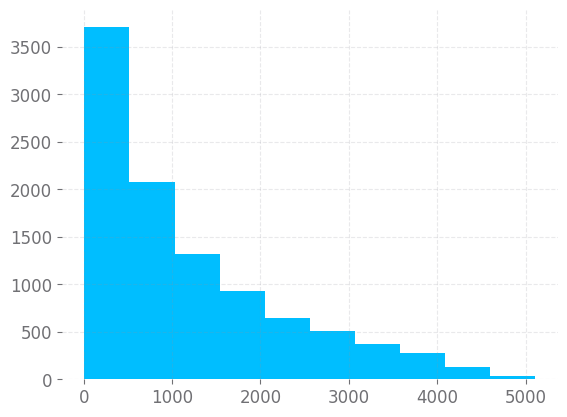

In [41]:
plt.hist(rprocess(pfs[213], theta, 
             np.array([jax.random.PRNGKey(onp.random.choice(10000)) for i in range(10000)]), covars)[:, 3])

(array([8493., 1197.,  216.,   62.,   21.,    8.,    0.,    1.,    1.,
           1.]),
 array([  3.94318175,  67.59960175, 131.25602722, 194.91244507,
        258.56887817, 322.22528076, 385.88171387, 449.53811646,
        513.19451904, 576.85095215, 640.50738525]),
 <BarContainer object of 10 artists>)

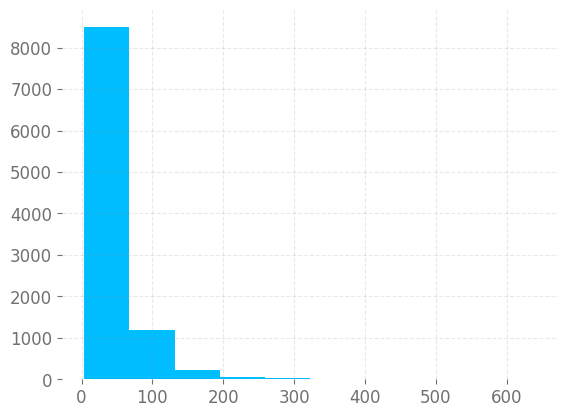

In [36]:
plt.hist(rprocess(np.hstack([np.array(pd.read_csv('data/dacca/pfs.csv', index_col=0)[['S', 'I', 'Y', 'deaths', 'R1', 'R2', 'R3']]),
           214*20*np.ones((10000,1)), np.zeros((10000,1))]), theta, 
             np.array([jax.random.PRNGKey(onp.random.choice(10000)) for i in range(10000)]), covars)[:,3])

In [29]:
normalize_weights(dmeasure(ys[214],
    rprocess(pfs[213], theta, 
             np.array([jax.random.PRNGKey(onp.random.choice(10000)) for i in range(10000)]), covars),
        theta)-np.log(10000))

(Array([-16.086033, -17.40416 , -16.772312, ..., -16.80936 , -16.748764,
        -16.838623], dtype=float32),
 Array(-8.343644, dtype=float32))

In [30]:
normalize_weights(dmeasure(ys[214],
    rprocess(np.hstack([np.array(pd.read_csv('data/dacca/pfs.csv', index_col=0)[['S', 'I', 'Y', 'deaths', 'R1', 'R2', 'R3']]),
           214*20*np.ones((10000,1)), np.zeros((10000,1))]), theta, 
             np.array([jax.random.PRNGKey(onp.random.choice(10000)) for i in range(10000)]), covars),
        theta)-np.log(10000))

(Array([-15.143157 , -14.91892  , -10.726606 , ...,  -7.183879 ,
         -7.1922007, -12.76464  ], dtype=float32),
 Array(-3.9541025, dtype=float32))

In [141]:
pd.read_csv('data/dacca/ll_pomp.csv', index_col=0)['.'].iloc[214]

-3.96286182815116

In [58]:
pd.read_csv('data/dacca/pfs.csv', index_col=0)

,S,I,Y,R1,R2,R3,deaths,W,count
X1908.83333333333.1,2.764283e+06,9179.178493,0,1670.415833,1244.256505,1176.590185,18.358016,-4.659638,0
X1908.83333333333.2,2.774168e+06,1448.177590,0,539.626110,529.119357,522.423259,7.035573,-5.093951,0
X1908.83333333333.3,2.774168e+06,1448.177590,0,539.626110,529.119357,522.423259,7.035573,-5.093951,0
X1908.83333333333.4,2.774168e+06,1448.177590,0,539.626110,529.119357,522.423259,7.035573,-5.093951,0
X1908.83333333333.5,2.774168e+06,1448.177590,0,539.626110,529.119357,522.423259,7.035573,-5.093951,0
...,...,...,...,...,...,...,...,...,...
X1908.83333333333.9996,2.775534e+06,823.684130,0,472.480481,487.674497,575.057719,7.619370,-5.638068,0
X1908.83333333333.9997,2.775534e+06,823.684130,0,472.480481,487.674497,575.057719,7.619370,-5.638068,0
X1908.83333333333.9998,2.775534e+06,823.684130,0,472.480481,487.674497,575.057719,7.619370,-5.638068,0
X1908.83333333333.9999,2.775534e+06,823.684130,0,472.480481,487.674497,575.057719,7.619370,-5.638068,0


In [57]:
pd.read_csv('data/dacca/pfs0.csv', index_col=0)

,S,I,Y,R1,R2,R3,deaths,W,count
X1908.91666666667.1,2.767580e+06,7494.634039,0,2035.974234,1545.239336,1213.552164,18.687984,-5.202577,0
X1908.91666666667.2,2.767580e+06,7494.634039,0,2035.974234,1545.239336,1213.552164,18.687984,-5.202577,0
X1908.91666666667.3,2.758851e+06,13715.790858,0,3192.112218,2440.032867,1662.487831,26.760286,-4.994317,0
X1908.91666666667.4,2.758804e+06,14918.177720,0,3056.555581,1861.605146,1225.757078,22.089562,-4.992185,0
X1908.91666666667.5,2.762265e+06,11335.561668,0,2765.107451,2097.421690,1402.916848,22.413508,-5.130849,0
...,...,...,...,...,...,...,...,...,...
X1908.91666666667.9996,2.769145e+06,7725.840461,0,1746.205272,1111.522876,830.525794,14.050521,-5.632319,0
X1908.91666666667.9997,2.769145e+06,7725.840461,0,1746.205272,1111.522876,830.525794,14.050521,-5.632319,0
X1908.91666666667.9998,2.769145e+06,7725.840461,0,1746.205272,1111.522876,830.525794,14.050521,-5.632319,0
X1908.91666666667.9999,2.769145e+06,7725.840461,0,1746.205272,1111.522876,830.525794,14.050521,-5.632319,0


In [56]:
(lls - pd.read_csv('data/dacca/ll_pomp.csv', index_col=0)['.']).iloc[214]

-4.304097

<Axes: >

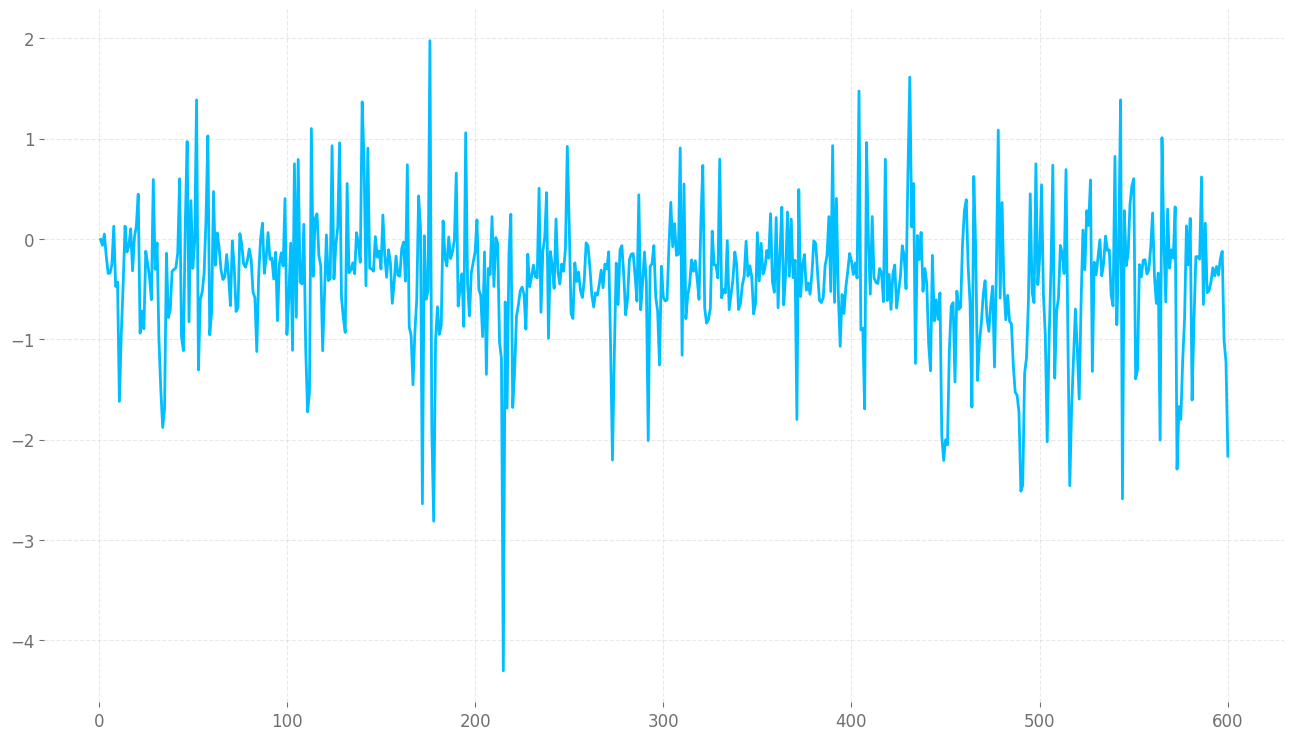

In [49]:
(lls - pd.read_csv('data/dacca/ll_pomp.csv', index_col=0)['.']).plot(figsize=(16,9))

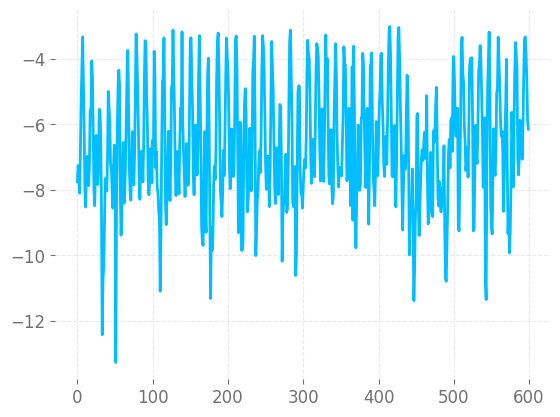

In [12]:
plt.plot(lls)

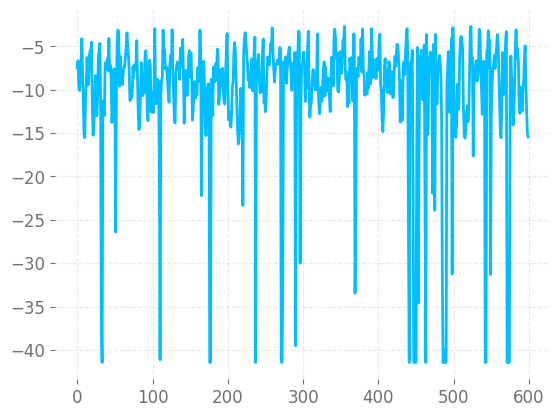

In [6]:
plt.plot(lls)

<Axes: >

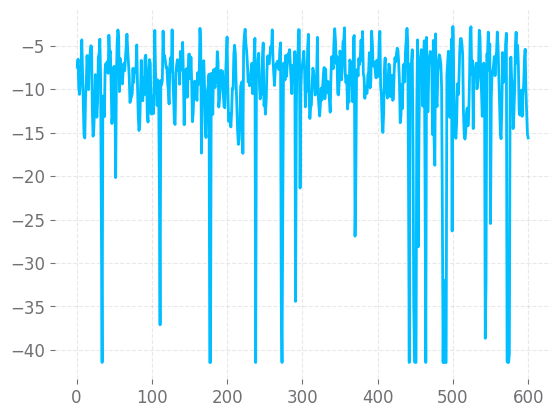

In [10]:
pd.read_csv('data/dacca/ll_pomp_sd_0.csv', index_col=0)['.'].plot()

<Axes: >

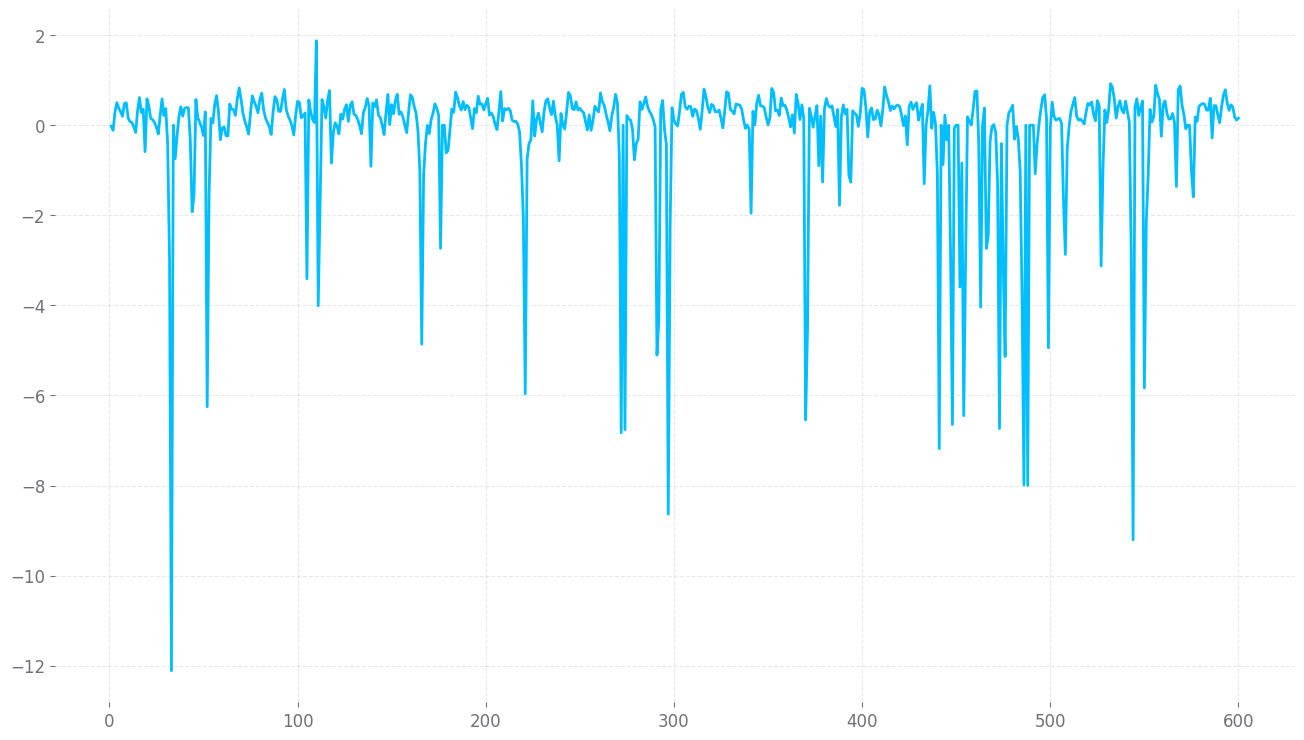

In [8]:
(lls - pd.read_csv('data/dacca/ll_pomp_sd_0.csv', index_col=0)['.']).plot(figsize=(16,9))

In [50]:
lls.sum() * 0.94

Array(-3742.8262, dtype=float32)

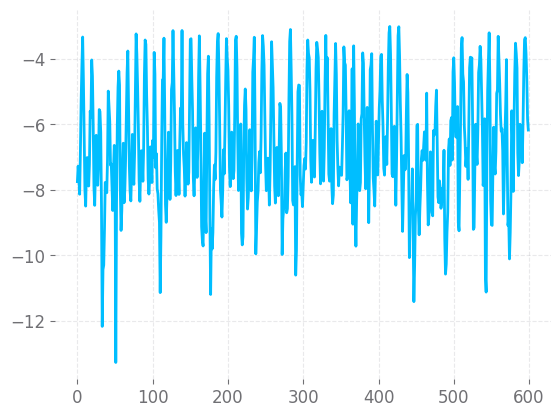

In [54]:
plt.plot(lls)

In [3]:
state = rinit(theta, 1, covars).squeeze()
keys = np.array([jax.random.PRNGKey(onp.random.choice(10000)) for i in range(2)])
print(rprocess(np.array([state, state]), theta, keys, covars)) 
print(rprocesses(np.array([state, state]), np.array([theta, theta]), keys, covars))

[[1406604.2     423801.9          0.        3236.3801  178564.36
   201973.55    210083.16        20.    ]
 [1406604.2     423801.9          0.        3236.3801  178564.36
   201973.55    210083.16        20.    ]]
[[1406604.2     423801.9          0.        3236.3801  178564.36
   201973.55    210083.16        20.    ]
 [1406604.2     423801.9          0.        3236.3801  178564.36
   201973.55    210083.16        20.    ]]


In [5]:
print(dmeasure(ys[0], np.vstack([rproc(state+i, theta, keys[0], covars) for i in range(20)]), theta))
print(dmeasures(ys[0], np.vstack([rproc(state+i, theta, keys[0], covars) for i in range(20)]), 
         np.vstack([theta+i for i in range(20)])))

[-7.851351  -7.815332  -7.781214  -7.7489424 -7.718454  -7.6896853
 -7.662572  -7.6370473 -7.613046  -7.590501  -7.5693474 -7.549519
 -7.5309525 -7.537484  -7.544163  -7.5509915 -7.5579705 -7.5651026
 -7.572391  -7.5798388]
[ -7.851351  -8.860641  -9.62187  -10.173655 -10.603394 -10.954595
 -11.251214 -11.507751 -11.733632 -11.935319 -12.117439 -12.283416
 -12.435852 -12.585667 -12.725382 -12.856299 -12.979485 -13.095823
 -13.206053 -13.310804]


In [8]:
thetas = theta + 1e-3*np.abs(theta)*onp.random.normal(size=theta.shape)
perfilter(thetas, ys, 1000, np.abs(theta)/100, covars=covars, a=0.9, thresh=0)

(Array(4261.8037, dtype=float32),
 Array([[  3.7366014,  -2.3886294,         nan, ...,  -2.799066 ,
         -12.556817 ,  -3.7673175],
        [  3.7366014,  -2.3886294,         nan, ...,  -2.799066 ,
         -12.556817 ,  -3.7673175],
        [  3.6644979,  -2.403528 ,         nan, ...,  -2.7425282,
         -12.563065 ,  -3.6966836],
        ...,
        [  3.732488 ,  -2.4840882,         nan, ...,  -2.6156435,
         -13.035588 ,  -3.8589156],
        [  3.732488 ,  -2.4840882,         nan, ...,  -2.6156435,
         -13.035588 ,  -3.8589156],
        [  3.732488 ,  -2.4840882,         nan, ...,  -2.6156435,
         -13.035588 ,  -3.8589156]], dtype=float32))

In [9]:
dmeas(2641, np.array([1.658749e+06, 2.427019e+05,  0.000000e+00, 3.005136e+03]), theta)

Array(-7.5961165, dtype=float32)

In [10]:
jax.scipy.stats.norm.logpdf(2641, loc=3.005136e+03, scale=0.23*3.005136e+03)

Array(-7.5961165, dtype=float32, weak_type=True)

In [66]:


dmeas(2641, np.array([1.626465e+06, 2.960543e+05, 0.000000e+00, 2.884684e+03]), theta)

Array(-7.483882, dtype=float32)

In [17]:
n_trials = 1
J = 5000

sigmas = (np.abs(theta)/600)
theta_ests = theta + 12*sigmas*onp.random.normal(size=theta.shape)

'''
gd_logliks, gd_ests = train(theta_ests, ys, covars, beta=0.9, eta=5e-4/600,
                            verbose=True, itns=20, J=J, thresh=0, method='SGD', scale=False)


newt_logliks, newt_ests = train(theta_ests, ys, covars, beta=0.9, eta=1e-2, c=1e-1, max_ls_itn=5, 
                            verbose=True, itns=20, J=J, Jh=500, thresh=0, method='Newton', scale=True, ls=True)

'''
#res = minimize(pfilter, x0=theta_ests, args=(ys, J, covars, 0), method='BFGS', options={'maxiter': 10})
get_thetas(theta_ests)

(Array(22.309761, dtype=float32),
 Array(0.06398365, dtype=float32),
 Array(0., dtype=float32),
 Array(18.47803, dtype=float32),
 Array(0.01016143, dtype=float32),
 Array(nan, dtype=float32),
 Array(-0.0049008, dtype=float32),
 Array(3.0244782, dtype=float32),
 Array(0.22194159, dtype=float32),
 Array([ 0.7648017,  6.2815833, -3.428807 ,  4.318423 ,  3.3546176,
         4.5383058], dtype=float32),
 Array([-1.6730338, -2.5518785, -2.888197 , -4.7106347, -8.670754 ,
        -4.4138246], dtype=float32),
 3,
 0.02)

In [ ]:
newt_logliks, newt_ests = train(theta_ests, ys[:100], covars, beta=0.9, eta=1e-1, c=1e-1, max_ls_itn=5, 
                            verbose=True, itns=20, J=J, Jh=500, thresh=100, method='Newton', scale=False, ls=True)

In [ ]:
weighted_newt_logliks, weighted_newt_ests = train(theta_ests, ys[:100], covars, beta=0.9, eta=1e-2, c=1e-1, max_ls_itn=5, 
                            verbose=True, itns=20, J=J, Jh=500, thresh=100, method='WeightedNewton', scale=False, ls=True)

In [ ]:
#make plot of runtime of backward pass vs number of particles and number of timesteps

#try adaptive swapping between IF2 and AD
#Benchmark local search when MLE found, for swapping to AD to be worth it

In [ ]:
bfgs_logliks, bfgs_ests = train(theta_ests, ys, covars, beta=0.9*10, eta=0.2, c=0.01, max_ls_itn=30, 
                            verbose=True, itns=20, J=J, thresh=0, method='BFGS', scale=True, ls=False)

In [18]:
mif_logliks, mif_params = mif(theta_ests, ys, sigmas=0.01*sigmas, 
                              sigmas_init = 6*sigmas, covars=covars,
                              M=20, J=J, a=0.95, monitor=True, thresh=0)

100%|██████████| 20/20 [00:22<00:00,  1.11s/it]


In [26]:
gd_logliks, gd_ests = train(theta_ests, ys, covars, beta=0.9, eta=0.01, 
                            verbose=False, itns=40, J=J, thresh=100, 
                            method='SGD', ls=False, scale=True)

100%|██████████| 40/40 [02:35<00:00,  3.88s/it]


In [ ]:
newtif_logliks, newtif_params = newtif(theta_ests, ys, sigmas=sigmas, 
                                       sigmas_init = sigmas, covars=covars, 
                                       M=100, J=J, Jh=500, a=0.95, beta=0.9, tau=5, 
                                       monitor=True, verbose=True, thresh=0)

NameError: name 'gd_logliks' is not defined

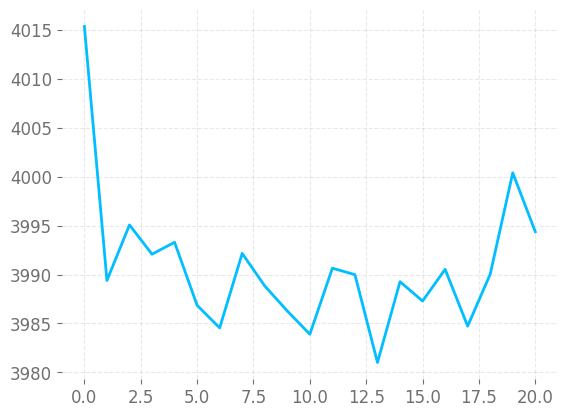

In [19]:
plt.plot(mif_logliks)
plt.plot(gd_logliks)
#plt.plot(bfgs_logliks)

In [28]:
get_thetas(mif_params[-1].mean(0))

(Array(21.109158, dtype=float32),
 Array(0.05653522, dtype=float32),
 Array(nan, dtype=float32),
 Array(20.37896, dtype=float32),
 Array(0.0111163, dtype=float32),
 Array(nan, dtype=float32),
 Array(-0.00486304, dtype=float32),
 Array(2.9366364, dtype=float32),
 Array(0.23603871, dtype=float32),
 Array([ 0.7533299,  6.265273 , -3.4684374,  4.175504 ,  3.3069859,
         4.3817763], dtype=float32),
 Array([-1.7145863, -2.5066683, -2.9177074, -4.602116 , -8.57713  ,
        -4.4398446], dtype=float32),
 3,
 0.02)

In [33]:
get_thetas(gd_ests[-1])

(Array(19.907322, dtype=float32),
 Array(0.05609335, dtype=float32),
 Array(nan, dtype=float32),
 Array(20.368866, dtype=float32),
 Array(0.01091034, dtype=float32),
 Array(nan, dtype=float32),
 Array(-0.00489187, dtype=float32),
 Array(2.9777403, dtype=float32),
 Array(0.25593454, dtype=float32),
 Array([ 0.79691195,  6.3122907 , -3.4624527 ,  4.20487   ,  3.4013658 ,
         4.364176  ], dtype=float32),
 Array([-1.7018726, -2.5281363, -2.9146302, -4.6078796, -8.641895 ,
        -4.403195 ], dtype=float32),
 3,
 0.02)

In [134]:
pd.DataFrame([newt_logliks, weighted_newt_logliks, bfgs_logliks, gd_logliks, mif_logliks, newtif_logliks], 
             index=['Newton', 'Weighted Newton', 'Quasi-Newton', 'Gradient Descent', 'IF2', 'Newton IF2']
            ).T.to_csv('data/dacca/fit1.csv')

In [81]:
#params = mif_params[-1].mean(0)
params = theta
traj = [rinit(params, 1, covars)]
for i in tqdm(range(len(ys))):
    traj.append(rprocess(traj[-1], params, 
                         np.array([jax.random.PRNGKey(onp.random.choice(10000)) for j in range(1)]), covars))
traj = traj[1:]

100%|██████████| 600/600 [00:00<00:00, 1429.17it/s]


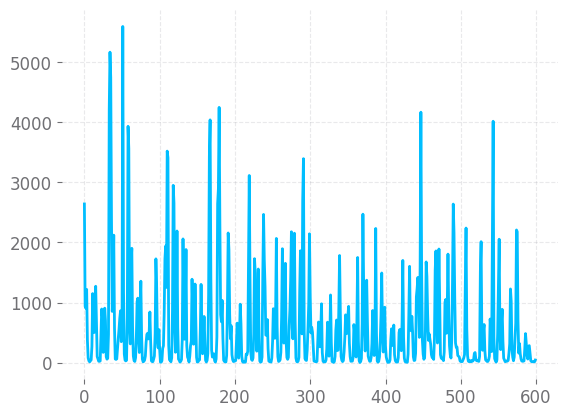

In [74]:
plt.plot(ys)

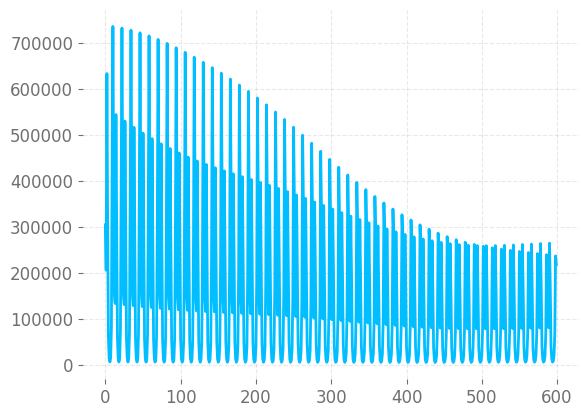

In [83]:
plt.plot(onp.array([onp.array(traj)[:,i,1] for i in range(1)]).T)
plt.ticklabel_format(style='plain') 
plt.show()

In [72]:
def rproc_debug(state, theta, key, covar):
    S, I, Y, deaths, pts, t = state[0], state[1], state[2], state[3], state[4:-1], state[-1]
    t = t.astype(int)
    trends, dpopdts, pops, seass = covar[:,0], covar[:,1], covar[:,2], covar[:,3:]
    gamma, deltaI, rho, eps, omega, clin, beta_trend, sd_beta, tau, bs, omegas, nrstage, delta = get_thetas(theta)
    dt = 1/240
    deaths = 0
    nrstage = 3
    clin = 1 # HARDCODED SEIR
    rho = 0 # HARDCODED INAPPARENT INFECTIONS
    std = onp.sqrt(dt)
    
    neps = eps*nrstage
    rdeaths = np.zeros(nrstage)
    passages = np.zeros(nrstage+1)
    

    for i in range(20):
        trend = trends[t]; dpopdt = dpopdts[t]; pop = pops[t]; seas = seass[t]
        beta = np.exp(beta_trend*trend + np.dot(bs, seas))
        omega = np.exp(np.dot(omegas, seas))
        
        subkey, key = jax.random.split(key)
        dw = jax.random.normal(subkey)*std #rnorm uses variance sqrt(dt), not stdev
        
        effI = I/pop
        births = dpopdt + delta*pop # births
        passages = passages.at[0].set(gamma*I) #recovery
        ideaths = delta*I #natural i deaths
        disease = deltaI*I #disease death
        ydeaths = delta*Y #natural rs deaths
        wanings = rho*Y #loss of immunity
        
        for j in range(nrstage):
            rdeaths = rdeaths.at[j].set(pts[j]*delta) #natural R deaths
            passages = passages.at[j+1].set(pts[j]*neps) # passage to the next immunity class
            
        infections = (omega+(beta+sd_beta*dw/dt)*effI)*S # infection
        sdeaths = delta*S # natural S deaths
        
        S += (births - infections - sdeaths + passages[nrstage] + wanings)*dt
        I += (clin*infections - disease - ideaths - passages[0])*dt
        Y += ((1-clin)*infections - ydeaths - wanings)*dt
        for j in range(nrstage):
            pts = pts.at[j].add((passages[j] - passages[j+1] - rdeaths[j])*dt)
        deaths += disease*dt # cumulative deaths due to disease
        
        S = np.clip(S, a_min=0); I = np.clip(I, a_min=0); Y = np.clip(Y, a_min=0)
        pts = np.clip(pts, a_min=0); deaths = np.clip(deaths, a_min=0)
        
        t += 1
        
    return np.hstack([np.array([S, I, Y, deaths]), pts, np.array([t])])

sigma = 0 #3.13 # 0.77

theta = transform_thetas(gamma, m, rho, epsilon, omega, c, beta_trend, sigma, tau, bs, omegas)

In [39]:
rproc_debug(np.array([1.626465e+06, 2.960543e+05,  0.000000e+00, 2.884684e+03, 
                      1.388140e+05,  1.704914e+05,  1.875851e+05, 20])
            , theta, jax.random.PRNGKey(0), covars)

Array([1988831.8   ,  201841.86  ,       0.    ,    1083.1101,
         70404.4   ,   74261.68  ,   84628.03  ,      40.    ],      dtype=float32)

In [15]:
[1.994709e+06, 1.992164e+05, 0.000000e+00, 1.070219e+03, 6.913215e+04, 7.313747e+04, 8.378465e+04]

[1994709.0, 199216.4, 0.0, 1070.219, 69132.15, 73137.47, 83784.65]

In [16]:
rproc_debug(rinit(theta, 1, covars).squeeze()
            , theta, jax.random.PRNGKey(0), covars)

Array([1614756.5   ,  303858.78  ,       0.    ,    2908.2844,
        141121.72  ,  172448.61  ,  189169.66  ,      20.    ],      dtype=float32)

In [20]:
dataset.iloc[20:]

,trend,dpopdt,pop,seas_1,seas_2,seas_3,seas_4,seas_5,seas_6
.,,,,,,,,,
1891.083333,-24.996667,19623.061922,2.422291e+06,0.648333,0.175889,0.000111,0.0,0.000444,0.175222
1891.087500,-24.992500,19623.101439,2.422373e+06,0.650542,0.187208,0.000125,0.0,0.000333,0.161792
1891.091667,-24.988333,19623.140957,2.422455e+06,0.652750,0.198528,0.000139,0.0,0.000222,0.148361
1891.095833,-24.984167,19623.180474,2.422537e+06,0.654958,0.209847,0.000153,0.0,0.000111,0.134931
1891.100000,-24.980000,19623.219991,2.422618e+06,0.657167,0.221167,0.000167,0.0,0.000000,0.121500
...,...,...,...,...,...,...,...,...,...
1941.133333,25.053333,90531.799899,4.234213e+06,0.578167,0.350167,0.007167,0.0,0.000000,0.064500
1941.137500,25.057500,90531.799899,4.234590e+06,0.568292,0.366292,0.008042,0.0,0.000000,0.057375
1941.141667,25.061667,90531.799899,4.234967e+06,0.558417,0.382417,0.008917,0.0,0.000000,0.050250


In [ ]:
variable          [,1]
S       1.994709e+06
I       1.992164e+05
Y       0.000000e+00
R1      6.913215e+04
R2      7.313747e+04
R3      8.378465e+04
deaths  1.070219e+03
W      -4.726358e-01
count   0.000000e+00

In [27]:
dmeasure(ys[1], traj[1], params)

Array([-8.456807, -9.18597 , -8.704758, -8.506664, -8.999603, -8.951179,
       -8.706633, -8.954659, -8.639873, -8.857249], dtype=float32)